# Regression Model Project
## Project Overview

This project focuses on building and validating a regression model using the provided dataset. The data was divided into two groups, referred to as "group1" and "group2." The regression model for both groups was assumed to be a polynomial function involving five variables: `time`, `var1`, `var2`, `var3`, and `var4`.

## Model Assumptions and Approach

- **Polynomial Regression Model**: The model was designed as a polynomial of the five variables mentioned above. The exponents for each variable were selected to maximize the R² (R-squared) value and minimize the p-value of the individual coefficients.

- **Ordinary Least Squares (OLS) Method**: The model was implemented using the *LinearRegression* method from the `scikit-learn` package in Python. Furthermore, *ElasticNet* and *Lasso* regressions were applied, with parameters optimized by *RandomizedSearchCV*.

## Data Splitting

The dataset was split into training and testing sets to evaluate the model's performance. The number of samples in each group is summarized as follows:
- **Training Data Count**: The number of samples used for training the model.
- **Testing Data Count**: The number of samples used for testing the model.

## Results and Visualization

- **Analysis Results**: The results of the regression analysis are presented in the accompanying report.
- **Scatter Plots**: Scatter plots of predicted vs actual values (test data) are provided at the end. These plots include residuals that are gradually colored to visualize the model's performance.

## Python code for realization
### Importing necessary modules

In [1]:
%matplotlib inline

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from statsmodels.tools.eval_measures import rmse

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.model_selection import RandomizedSearchCV

### Reading data

In [3]:
iDir = 'input/'
pDir = 'plots/'

fnam = 'data.csv'
df = pd.read_csv(iDir + fnam,sep=',',header=0)
display(df.head())
display(df.tail())


,group,time,var1,var2,var3,var4,dependent
0,group1,1,971.508984,0.375901,0.798304,0.000505,77.978494
1,group1,2,978.746614,0.606482,3.408306,1.438227,91.263548
2,group1,3,964.288875,0.093051,1.090679,8.442052,174.937467
3,group1,4,970.080293,0.703748,0.174558,8.229052,217.505983
4,group1,5,1003.203341,0.636575,0.719953,2.394819,208.658537


,group,time,var1,var2,var3,var4,dependent
395,group2,6,1032.505647,0.913059,1.777408,2.243348,556.749577
396,group2,7,926.838727,0.342892,2.413539,7.359040,574.942405
397,group2,8,1092.332355,0.896533,0.640897,7.379278,659.188613
398,group2,9,956.600960,0.027689,3.658717,8.462679,637.243075
399,group2,10,1015.365325,0.302600,3.149446,6.760243,658.119112


File *data.csv* contains data compound with variables *time*, *var1*, *var2*, *var3*, *var4* which will be features, and *dependent* variable which will be output of regression.

### Feature inspection
Feature inspection is carried out by plotting pairplot for each group of features. It should reveal dependance of each feature and outliers existance.

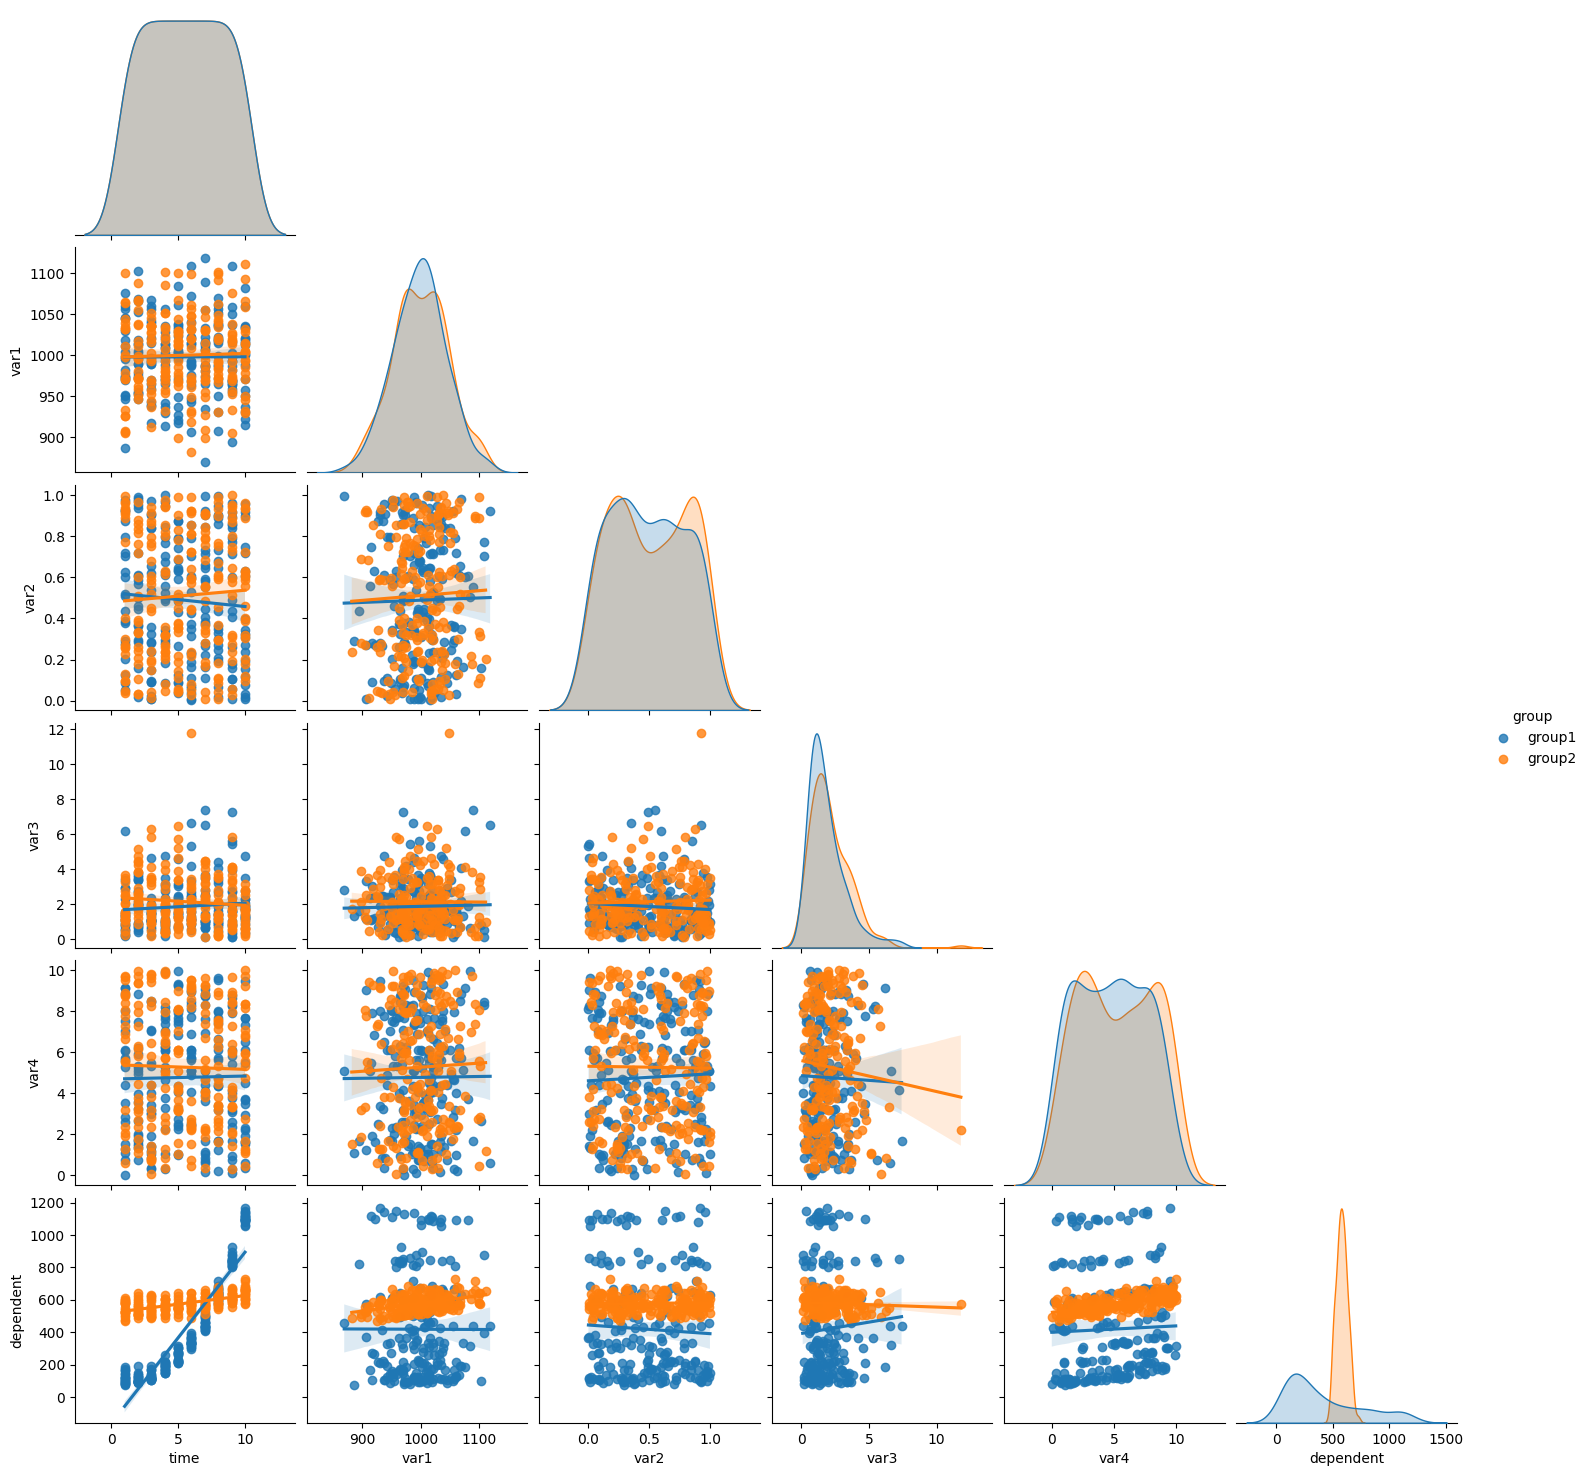

In [4]:
fig = sns.pairplot(df,kind='reg', diag_kind='kde',corner=True,hue='group',aspect=1)
fig.savefig(pDir + 'pairplot-all.png',dpi=150)

The pairplot shows the correlation and the distribution of each feature's data, as well as outliers, which are primarily visible for the feature **var3**. In the next step, the boxplots should help identify outliers in the dataset.

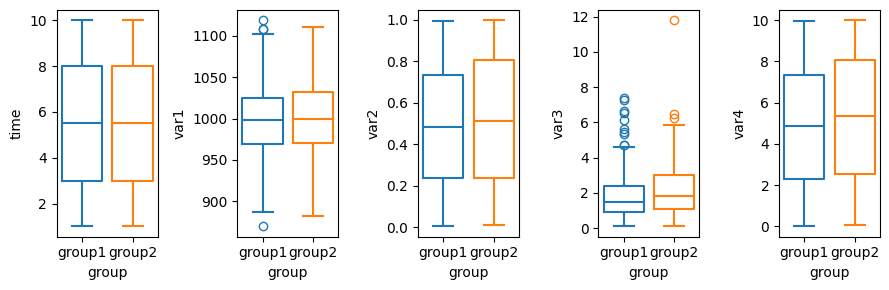

In [5]:
key = df.columns[1:-1]

def plboxp(df,key,fnam):
    fig, ax = plt.subplots(1,len(key),figsize=(9,3))
    for i,k in enumerate(key):
        sns.boxplot(data=df,y=k,x='group',hue='group',fill=False,ax=ax[i],orient='v')
    
    fig.tight_layout()
    fig.savefig(pDir + fnam + '.png',dpi=150)

plboxp(df,key,'boxplot-all')


The boxplots presented above showed two variables with outliers: **var1** and **var3**. The next step is to remove the outliers from the entire dataset and check data by boxplots again. This will obviously reduce the number of data points.

   Size of original dataset: 400
Size of dataset wo outliers: 348


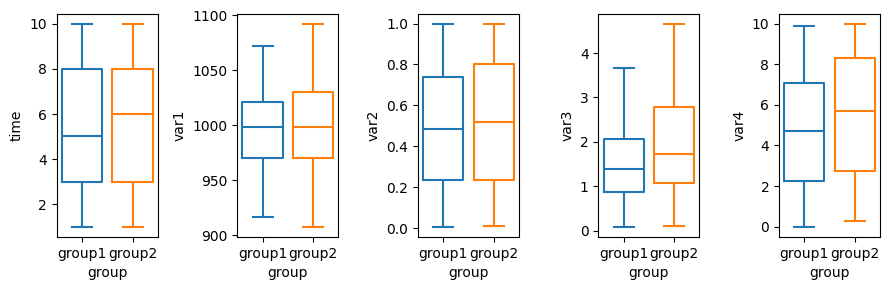

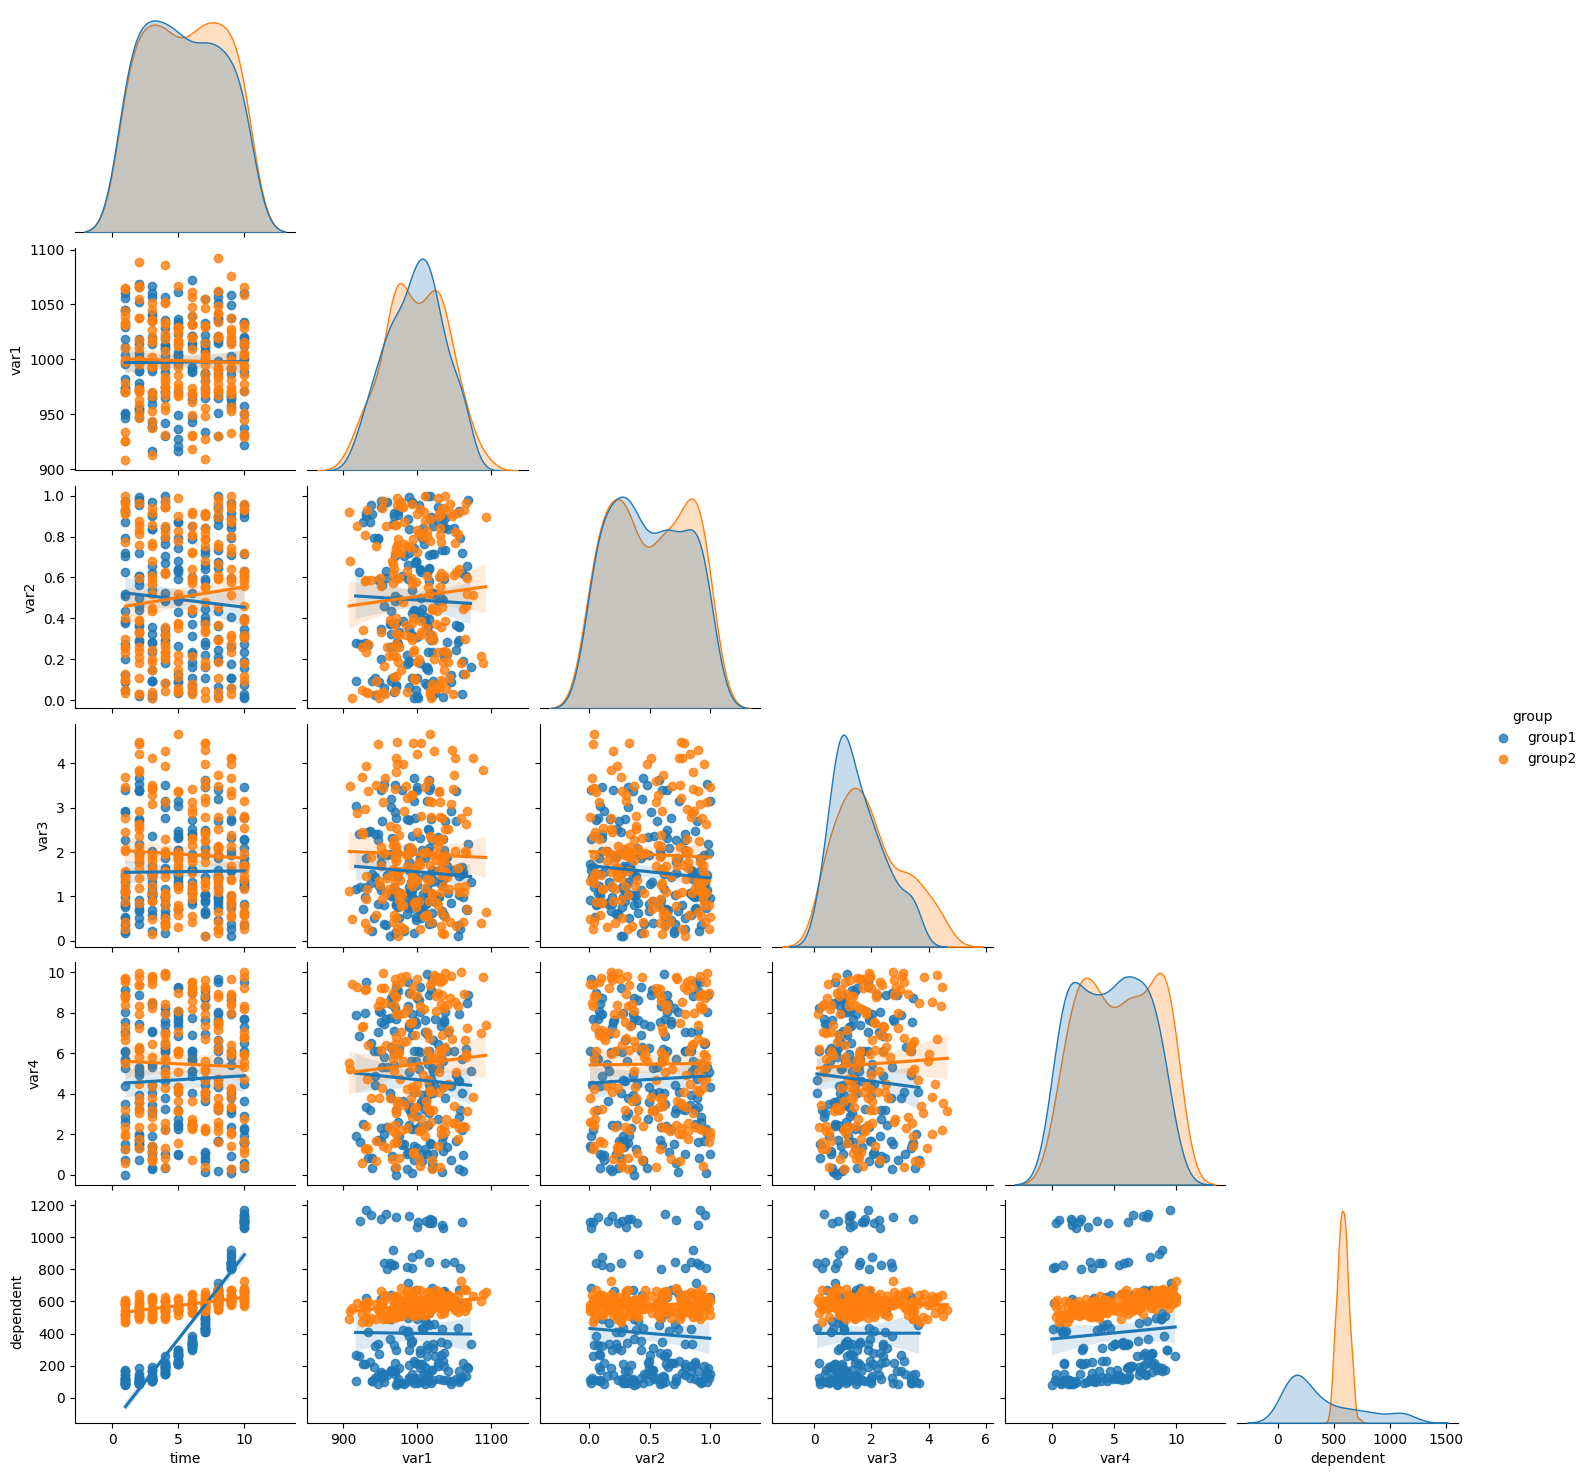

In [6]:
def outlim(ser):
    iqr = np.diff(np.percentile(ser,[25,75]))[0]
    med = np.median(ser)
    return(med-1.5*iqr,med+1.5*iqr)
dfn = pd.DataFrame()

for g in ['group1','group2']:
    kg = df.group == g
    dfi = df[kg]
    k = True
    for ke in key:
        lLim,uLim = outlim(dfi[ke])
        k1 = (dfi[ke]<=uLim) & (dfi[ke]>=lLim)
        k = k*k1

    dfn = pd.concat([dfn,dfi[k]])

print('   Size of original dataset:',df.shape[0])
print('Size of dataset wo outliers:',dfn.shape[0])
plboxp(dfn,key,'boxplot-clean')

fig = sns.pairplot(dfn,kind='reg', diag_kind='kde',corner=True,hue='group',aspect=1)
fig.savefig(pDir + 'pairplot-clean.png',dpi=150)

## Building regression model


  group1 metrics
LinearRegression
             R^2: 0.99881
            RMSE:    11.4
       Ridge
             R^2: 0.99881
            RMSE:    11.4
  ElasticNet
             R^2: 0.99865
            RMSE:    12.1



,dependent,LinearRegression,Ridge,ElasticNet
0,507.657517,514.850511,514.839922,511.900408
1,230.432623,230.573648,230.562119,226.070014
2,829.637545,847.720906,847.709443,845.319039
3,307.856923,307.143149,307.143973,306.715620
4,164.142295,164.501944,164.498387,162.291717


,dependent,LinearRegression,Ridge,ElasticNet
count,52.000000,52.000000,52.000000,52.000000
mean,432.499308,432.846722,432.850026,433.641990
std,334.491816,336.344699,336.346592,336.817717
min,91.263548,84.447435,84.558223,93.877991
25%,166.918929,164.182948,164.178347,162.103894
50%,301.535470,305.335308,305.339311,306.578190
75%,663.019833,647.487999,647.477661,645.121225
max,1127.525331,1145.852134,1145.865846,1147.286610



  group2 metrics
LinearRegression
             R^2: 0.99898
            RMSE:     1.7
       Ridge
             R^2: 0.99898
            RMSE:     1.7
  ElasticNet
             R^2: 0.99840
            RMSE:     2.1



,dependent,LinearRegression,Ridge,ElasticNet
0,608.761172,609.147593,609.136615,607.303998
1,530.814438,532.415825,532.423993,533.978687
2,657.502071,658.345815,658.351385,658.910836
3,601.982826,603.432425,603.440821,604.676608
4,575.974219,577.308041,577.308286,577.283809


,dependent,LinearRegression,Ridge,ElasticNet
count,54.000000,54.000000,54.000000,54.000000
mean,575.284763,575.671177,575.670644,575.616985
std,52.692620,53.071082,53.071749,52.939619
min,471.135740,472.114505,472.106454,471.292190
25%,540.943920,540.221208,540.224484,540.721976
50%,572.291184,572.595226,572.597545,572.999240
75%,606.588437,606.903032,606.904151,606.647150
max,676.274773,677.451286,677.452290,677.215908


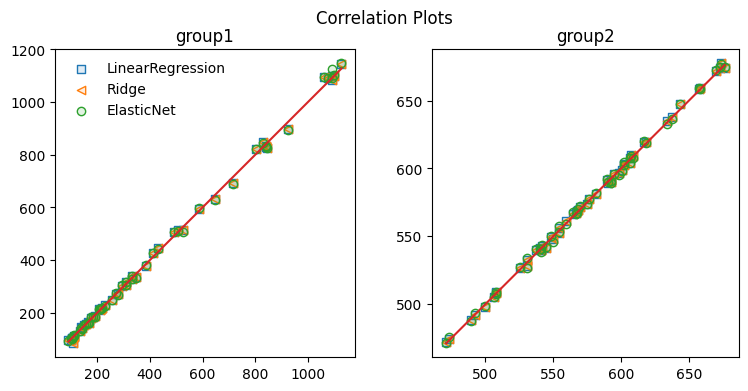

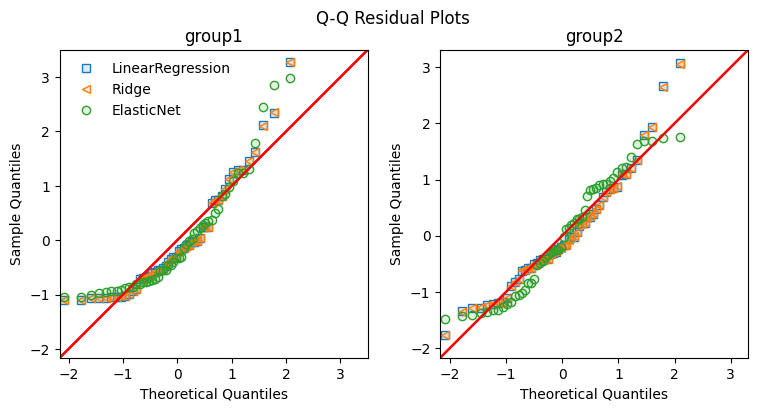

In [32]:
npow =  {'group1':[3.0,1.0,-.5,2.0,2.0],
         'group2':[2.0,1.0,1.0,1.0,2.0]}

SEED = 1311131


y = dfn.dependent
X = pd.DataFrame()

model_name = ['LinearRegression','Ridge','ElasticNet']
model      = [LinearRegression(fit_intercept=True),
              Ridge(fit_intercept=True),
              ElasticNet(fit_intercept=True)]

p_dist = {'ElasticNet':{ 'alpha' : np.linspace(0.1,99.9,990), 'l1_ratio' : np.linspace(0.1,0.9,9),'tol' : [1e-4,1e-3,1e-2,1e-1]},
          'Ridge':{'alpha' : np.linspace(0.1,.9,990)},
         }

col = ['#1f77b4','#ff7f0e','#2ca02c']
mar = ['s','<','o']

fig,ax = plt.subplots(1,2,figsize=(9,4))
fig.suptitle('Correlation Plots')

fiq,axq = plt.subplots(1,2,figsize=(9,4))
fiq.suptitle('Q-Q Residual Plots')

for i,g in enumerate(['group1','group2']):
    for ii,n in enumerate(npow[g]):
        X[key[ii]] = dfn[key[ii]]**n

    k = dfn.group == g

    X_train, X_test, y_train, y_test = train_test_split(X[k], y[k], test_size = 0.3 , random_state = SEED)

    vpr = []

    print('\n%8s metrics'%(g))
    s = [100,50,25]

    for ii,m in enumerate(model):

        if model_name[ii] != 'LinearRegression':
            rsh = RandomizedSearchCV(estimator=m, param_distributions=p_dist[model_name[ii]])
            rsh.fit(X_train, y_train)
            bp = rsh.best_params_
            m.set_params(**bp)

        m.fit(X_train,y_train)
        y_pred = m.predict(X_test)
        vpr.append(y_pred)

        print('%12s'%model_name[ii])
        print('%16s:%8.5f'%('R^2',m.score(X_test,y_test)))
        print('%16s:%8.1f'%('RMSE',rmse(y_pred,y_test)))

        res = np.abs(y_test-m.predict(X_test))*10
        
        ###### Correlation Plots
        ax[i].scatter(y_test,y_pred,ec=col[ii],marker=mar[ii],fc=col[ii]+'22',label=model_name[ii])

        #### Q-Q Residual Plots
        fiq = sm.qqplot(res, marker = mar[ii], markeredgecolor=col[ii], markerfacecolor=col[ii]+'22', ax=axq[i], fit=True,
                        line='45', label=model_name[ii])
        axq[i].set_title(g)
        axq[i].set_aspect(1)

    
    print()
    ax[0].legend(frameon=False)
    axq[0].legend(frameon=False)
    xL = [min(y_test),max(y_test)]
    ax[i].plot(xL,xL,c='tab:red')
    ax[i].set_aspect(1)
    ax[i].set_title(g)

    dfr = pd.DataFrame(data=vpr).T
    dfr.columns = model_name
    dfr = pd.concat([y_test.reset_index(drop=True),dfr],axis=1)
    display(dfr.head())
    display(dfr.describe())
    